In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1',parse_dates=True)
engage = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [3]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index('time_stamp', drop= True)

In [6]:
from datetime import timedelta

def label_adopted(x):    
    df_temp = engage.loc[engage['user_id'] == x] 
    df_temp = df_temp.resample('D').mean().dropna() 
    adopted = 0
    for i in range(len(df_temp)-2):
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): 
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [7]:
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [8]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


In [9]:
users.creation_time = pd.to_datetime(users.creation_time)
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
users['usage_length'] = users['last_session_creation_time'] - users['creation_time']
users['usage_length'] = [x.total_seconds() for x in users['usage_length']]
users['email_provider'] = [x.split('@')[1] for x in users.email]
top_emails = users.email_provider.value_counts().index[:6]
users['email_provider'] = [x if x in top_emails else 'other' for x in users.email_provider]
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

feature_df = users.iloc[:,4:]
feature_df = feature_df.drop('last_session_creation_time', axis=1)
feature_df['usage_length'] = feature_df['usage_length'].fillna(0)

In [10]:
gle = LabelEncoder()
creation_labels = gle.fit_transform(users['creation_source'])
feature_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users['org_id'])
feature_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users['invited_by_user_id'])
feature_df.org_id = invited_labels

email_labels = gle.fit_transform(users['email_provider'])
feature_df.email_provider = email_labels


In [11]:
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,-14400.0,6
1,1,0,0,56,316.0,1,11736000.0,2
2,1,0,0,298,1525.0,0,-14400.0,2
3,0,0,0,1104,5151.0,0,72000.0,6
4,0,0,0,1127,5240.0,0,414000.0,6


In [12]:
data = feature_df.drop('adopted_user', axis=1)
labels = feature_df.adopted_user

X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train, X_test)
rf.score(y_train, y_test)

0.9707070707070707

In [23]:
y_pred = rf.predict(y_train)
print(classification_report(y_test, y_pred))
cm= confusion_matrix(y_test,y_pred)
print('\nconfusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.92      0.87      0.89       553

    accuracy                           0.97      3960
   macro avg       0.95      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960


confusion matrix:
[[3364   43]
 [  73  480]]


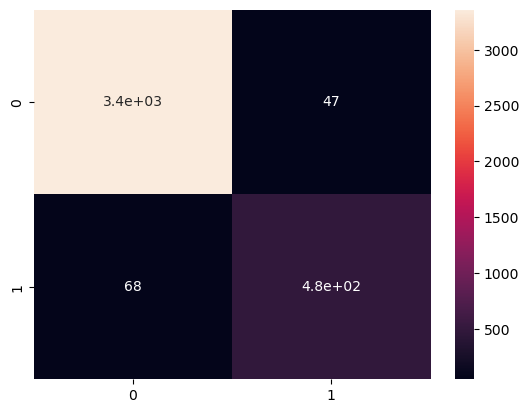

In [15]:
sns.heatmap(cm, annot = True);

In [16]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(data.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.920086
invited_by_user_id            0.024663
org_id                        0.022447
email_provider                0.014857
creation_source               0.010979
opted_in_to_mailing_list      0.003568
enabled_for_marketing_drip    0.003400
Name: coef, dtype: float64

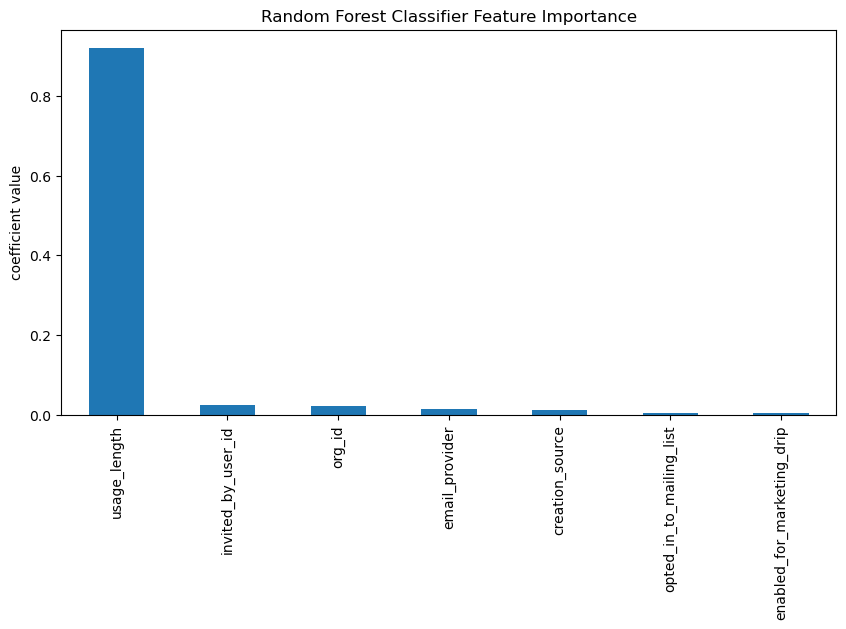

In [17]:
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

In [18]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [19]:
adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 1]
not_adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 0]

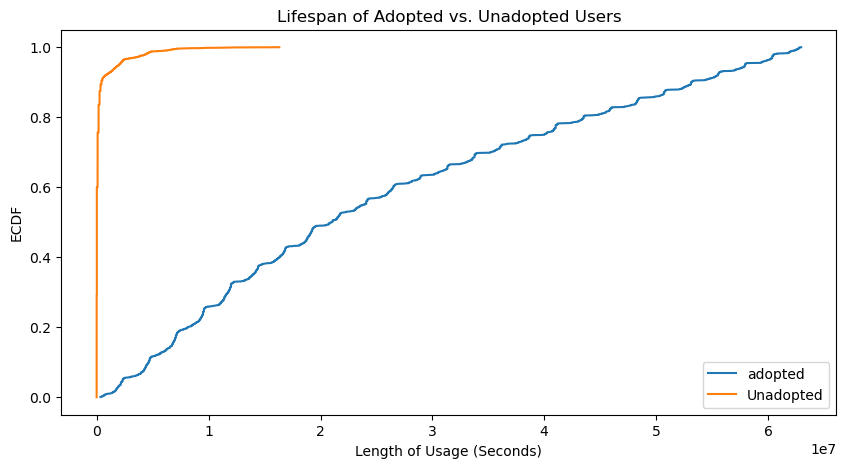

In [20]:
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active )
plt.plot(x_inactive, y_inactive)
plt.title('Lifespan of Adopted vs. Unadopted Users')
plt.xlabel('Length of Usage (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'Unadopted'])
plt.show()